In [2]:
import neuromancer.psl as psl
from neuromancer.dynamics import ode
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from scipy.integrate import solve_ivp

from tqdm.auto import tqdm
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'serif'

/Users/Malachite/Documents/github/stable_node_control/.venv311/lib/python3.11/site-packages/mlflow/utils/requirements_utils.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


**System model**:  
The system dynamics is defined by following nonlinear ordinary differential equations (ODEs):
$$
 \frac{dx_1}{dt} = c_1 (1.0 - v)  p - c_2  \sqrt{x_1}  \\  
 \frac{dx_2}{dt}  = c_1 v p + c_2  \sqrt{x_1} - c_2 \sqrt{x_2}
$$  
With system states $x_1$, and $x_2$ representing liquid levels in tank 1 and 2, respectively. Control actions are pump modulation $p$, and valve opening $v$. The ODE system is parametrized by inlet and outlet valve coefficients $c_1$ and $c_2$, respectively.

**Rewritten Formulation**:

$$
\dot x_1 = f_1(x_1, x_2) (x_1 - g_1(x_1,x_2)) \\
\dot x_2 = f_2(x_1,x_2) (x_2 - g_2(x_1,x_2))
$$

where
$$
f_1(x_1,x_2) \triangleq - \frac{c_2}{\sqrt{x_1}} \quad \text{and} \quad g_1(x_1, x_2) \triangleq (1-v)p\frac{c_1}{c_2}\sqrt{x_1},
$$
$$
f_2(x_1, x_2) \triangleq - \frac{c_2}{\sqrt{x_1}+\sqrt{x_2}} \quad \text{and} \quad g_2(x_1, x_2) \triangleq x_1 +v p \frac{c_1}{c_2}(\sqrt{x_1}+\sqrt{x_2})
$$

<!-- $$
f_2(x_1, x_2) \triangleq - \frac{c_2}{\sqrt{x_2}}, \quad \text{and} \quad g_2(x_1, x_2) \triangleq \sqrt{x_2} \left( \sqrt{x_1} + \frac{c_1 v p}{c_2} \right)

$$ -->

<!-- $$
\dot x_1 = - \frac{c_2}{\sqrt{x_1}} \left(x - \frac{c_1}{c_2}(1-v)p \sqrt{x_1}\right)\\
\dot x_2 = - \frac{c_2}{\sqrt{x_1} + \sqrt{x_2}}\left[x_2 - \left(x_1 + vp \frac{c_1}{c_2}(\sqrt{x_1}+\sqrt{x_2})\right)\right]
$$ -->

### Neuromancer Function

In [3]:
gt_model = psl.nonautonomous.TwoTank()

In [4]:
variables, constants, parameters, _ = gt_model.params

In [5]:
x0 = variables['x0']
ts = constants['ts']
c1,c2 = parameters["c1"], parameters["c2"]

In [6]:
c1,c2

(0.08, 0.04)

In [5]:
two_tank_ode_nm = ode.TwoTankParam()
two_tank_ode_nm.c1 = nn.Parameter(torch.tensor(gt_model.c1), requires_grad=False)
two_tank_ode_nm.c2 = nn.Parameter(torch.tensor(gt_model.c2), requires_grad=False)



# No internal constraints?
def two_tank_ode(t,x,u):
    with torch.no_grad():
        dh =  two_tank_ode_nm.ode_equations(
            torch.tensor([x]),
            torch.tensor([u])
        )
        return dh.squeeze().numpy()

In [6]:
x0 = [0.5,0.5]
u=[1,0.2]
two_tank_ode(0,x0,u)

array([0.03571573, 0.016     ], dtype=float32)

In [7]:
t_max= 300

sol = solve_ivp(
    two_tank_ode,
    t_span=[0,t_max],
    y0 = x0,
    t_eval=np.linspace(0,t_max,501),
    args=(u,)
)

/var/folders/9x/8bf0hckd1b122g3zlj_z9c1w0000gp/T/ipykernel_82457/1026455973.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  torch.tensor([x]),


(0.0, 8.14935837412893)

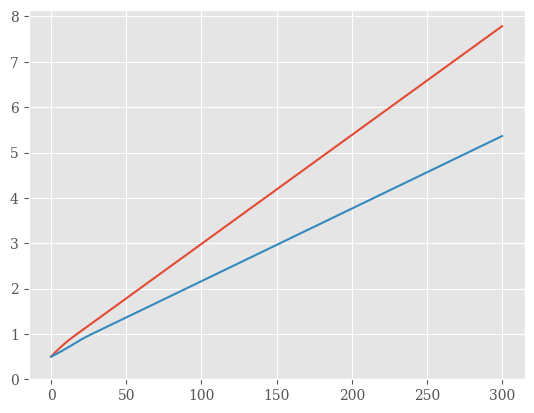

In [8]:
plt.plot(sol.t,sol.y[0,:])
plt.plot(sol.t,sol.y[1,:])
plt.ylim(0,)

### Rewritten Two-Tank with constraints to inside $[0,1]$.

Numerical drift does cause solution to fall outside of range


In [3]:
from scipy.integrate import solve_ivp

In [4]:
def two_tank_ode(t, x, u, c, eps=0.):
    x1, x2 = x
    p, v = u
    c1, c2 = c

    pump = np.clip(p, 0.0, 1.0)
    valve = np.clip(v, 0.0, 1.0)

    dhdt1 = c1*(1.0 - valve)*pump - c2*np.sqrt(max(x1, 0.0))
    dhdt2 = c1*valve*pump + c2*np.sqrt(max(x1, 0.0)) - c2*np.sqrt(max(x2, 0.0))

    if x1 <= 0.0+eps and dhdt1 < 0.0:
        dhdt1 = 0.0
    if x1 >= 1.0-eps and dhdt1 > 0.0:
        dhdt1 = 0.0

    if x2 <= 0.0+eps and dhdt2 < 0.0:
        dhdt2 = 0.0
    if x2 >= 1.0-eps and dhdt2 > 0.0:
        dhdt2 = 0.0

    return np.array([dhdt1, dhdt2])


In [10]:
x0 = [0.5,0.5]
u = [1,0.2]
c = [c1,c2]
eps = 2e-2

In [11]:
t_max = 100
sol = solve_ivp(
    two_tank_ode,
    t_span = [0,t_max],
    y0 = np.array(x0),
    t_eval= np.linspace(0,t_max, 501),
    args =(u,c,)
)

# soft_two_tank = lambda t,x,u,c: two_tank_ode(t,x,u,c,eps=1e-2)

sol2 = solve_ivp(
    two_tank_ode,
    t_span = [0,t_max],
    y0 = np.array(x0),
    t_eval= np.linspace(0,t_max, 501),
    args =(u,c,eps)
)


In [12]:
t = sol.t
X = sol.y

t2 = sol2.t
X2 = sol2.y

In [13]:
X.max(), X.min(), X2.min(), X2.max()

(1.0239694644875816, 0.5, 0.5, 1.0070201312215667)

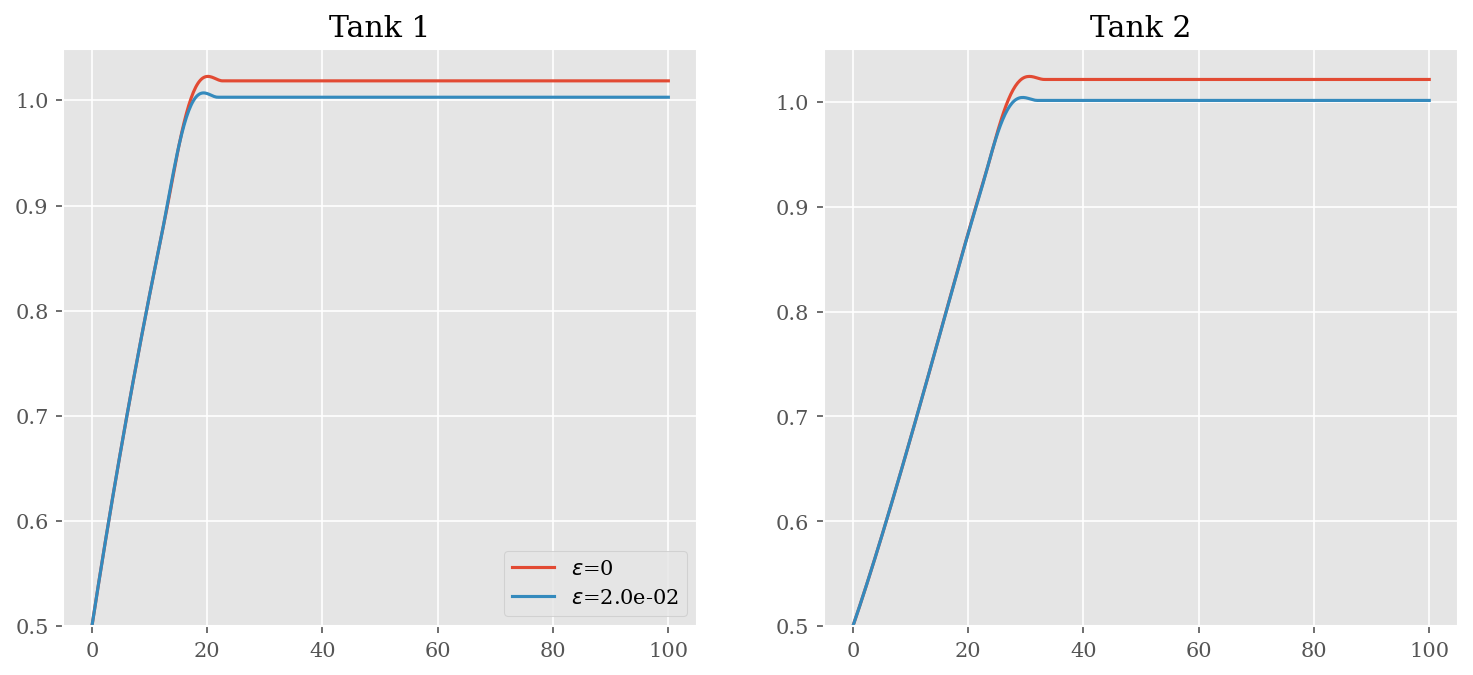

In [14]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5),dpi=150)

ax1.set_title("Tank 1")
ax1.plot(t, X[0,:],label=fr"$\epsilon$=0")
ax1.plot(t2,X2[0,:],label=fr"$\epsilon$={eps:.1e}")
ax1.set_ylim(0.5,)
ax1.legend(prop={'family':'serif'})

ax2.set_title("Tank 2")
ax2.plot(t,X[1,:])
ax2.plot(t2,X2[1,:])
ax2.set_ylim(0.5,)
plt.show()

In [36]:
p_vals = np.linspace(0,1,101)
v_vals = np.linspace(0,1,101)

eps = 9e-2
eps = 0.15

X1s = np.zeros((len(p_vals),len(v_vals)))
X2s = np.zeros((len(p_vals),len(v_vals)))

for i, pi in enumerate(tqdm(p_vals)):
    for j, vi in enumerate(tqdm(v_vals,leave=False)):
        t_max = 300
        x0 = [0.5,0.5]
        u = np.array([pi,vi])
        c = np.array([c1,c2])
        sol = solve_ivp(
            two_tank_ode,
            t_span = [0,t_max],
            y0 = np.array(x0),
            t_eval= np.linspace(0,t_max, 501),
            args =(u,c,eps)
        )
        x1, x2 = sol.y[:,-1]
        X1s[i,j] = x1
        X2s[i,j] = x2

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

In [37]:
X1s.max(),X1s.min(), X2s.max(), X2s.min()

(0.9865122166140967,
 0.07729118215486055,
 1.0438843236958315,
 0.14399168818316357)

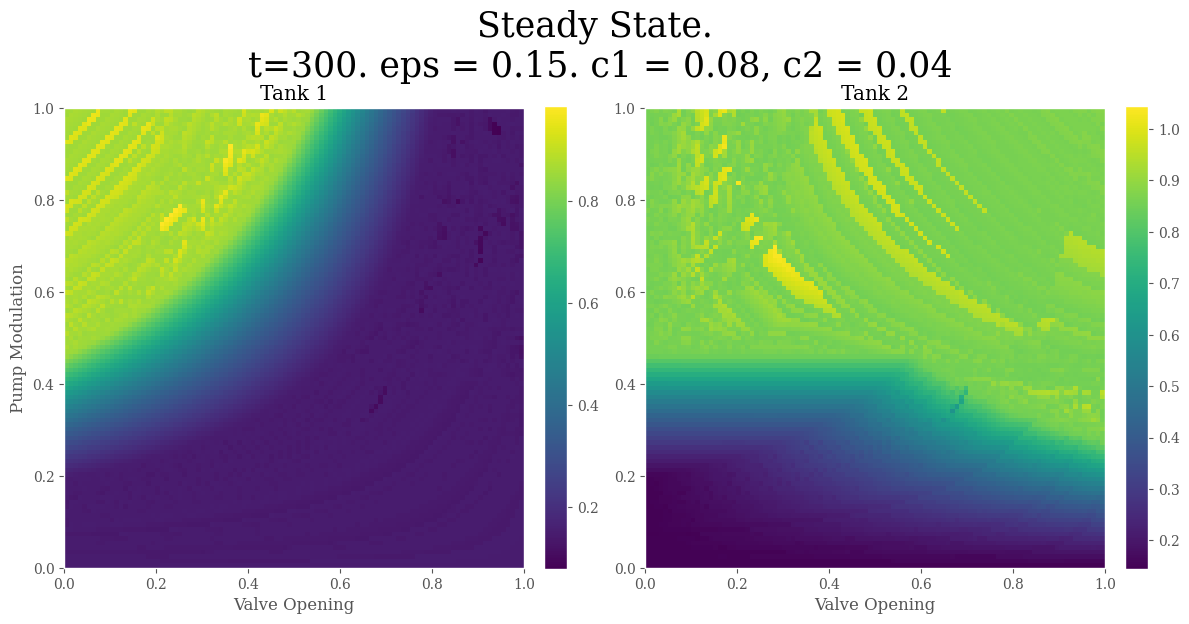

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
im1 = ax1.imshow(X1s,extent=[v_vals[0],v_vals[-1],p_vals[0],p_vals[-1]],origin='lower')
cbar1 = fig.colorbar(im1,ax=ax1,fraction=0.046,pad=0.04)
ax1.set_ylabel("Pump Modulation")
ax1.set_xlabel("Valve Opening")
ax1.set_title("Tank 1")
ax1.grid(False)

im2 = ax2.imshow(X2s,extent=[v_vals[0],v_vals[-1],p_vals[0],p_vals[-1]],origin='lower')
cbar2 = fig.colorbar(im2,ax=ax2,fraction=0.046,pad=0.04)
ax2.set_xlabel("Valve Opening")
ax2.set_title("Tank 2")
ax2.grid(False)

plt.suptitle(f"Steady State.\n t={t_max}. eps = {eps}. c1 = {c1}, c2 = {c2}",size=25)
plt.tight_layout()

## Look at $g_1$  and $g_2$

In [54]:
def g1(x,y,p,v,c1=c1,c2=c2):
    return (1-v)*p*c1/c2*np.sqrt(x)

def g2(x,y,p,v,c1=c1,c2=c2):
    return v*p*c1/c2*(np.sqrt(x)+np.sqrt(y))

def g2(x,y,p,v,c1=c1,c2=c2):
    return np.sqrt(y)*(np.sqrt(x)+c1/c2*v*p)

In [55]:
p = 0.1
v = 0.1

x1_lin = np.linspace(0,1,101)
x2_lin = np.linspace(0,1,101)

X1, X2 = np.meshgrid(x1_lin,x2_lin)

Z1 = g1(x=X1,y=X2,p=p,v=v)
Z2 = g2(x=X1,y=X2,p=p,v=v)

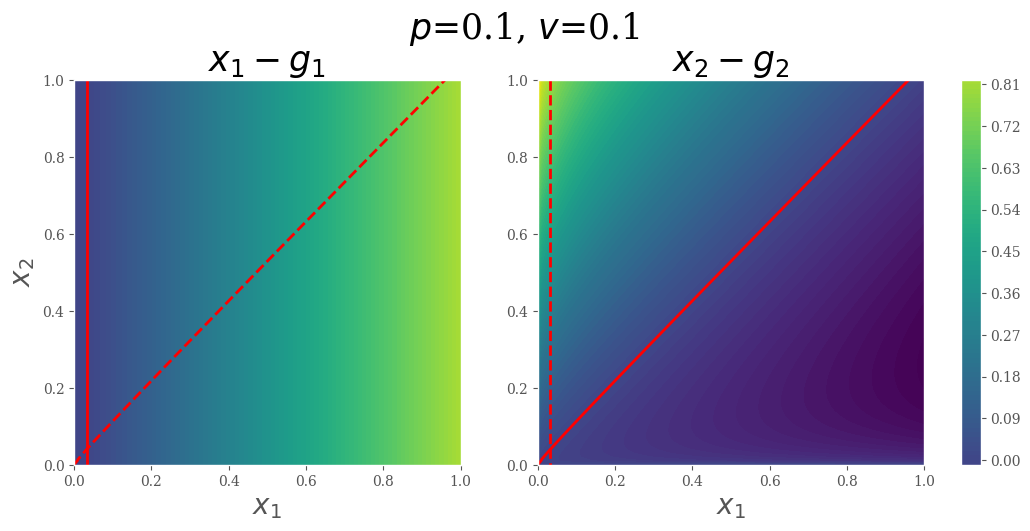

In [56]:
p = 0.1
v = 0.1

x1_lin = np.linspace(0,1,101)
x2_lin = np.linspace(0,1,101)

X1, X2 = np.meshgrid(x1_lin,x2_lin)

Z1 = g1(x=X1,y=X2,p=p,v=v)
Z2 = g2(x=X1,y=X2,p=p,v=v)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))


vmin = min((X1 - Z1).min(), (X2 - Z2).min())
vmax = max((X1 - Z1).max(), (X2 - Z2).max())
# vmin=None
# vmax=None

im1 = ax1.contourf(X1, X2, X1 - Z1, levels=100, vmin=vmin, vmax=vmax)
im2 = ax2.contourf(X1, X2, X2 - Z2, levels=100, vmin=vmin, vmax=vmax)

ax1.contour(X1, X2, X1 - Z1, levels=[0], colors='red', linewidths=2)
ax2.contour(X1, X2, X2 - Z2, levels=[0], colors='red', linewidths=2)

ax2.contour(X1, X2, X1 - Z1, levels=[0], colors='red', linewidths=2,linestyles='--')
ax1.contour(X1, X2, X2 - Z2, levels=[0], colors='red', linewidths=2,linestyles='--')

cbar = fig.colorbar(im1, ax=[ax1, ax2], fraction=0.046, pad=0.04)

ax1.set_ylabel(r"$x_2$", size=20)
ax1.set_xlabel(r"$x_1$", size=20)
ax1.set_title(r"$x_1 - g_1$", size=25)

ax2.set_xlabel(r"$x_1$", size=20)
ax2.set_title(r"$x_2 - g_2$", size=25)

# plt.tight_layout()
plt.suptitle(rf"$p$={p}, $v$={v}",size=25,y=1.02)
plt.show()


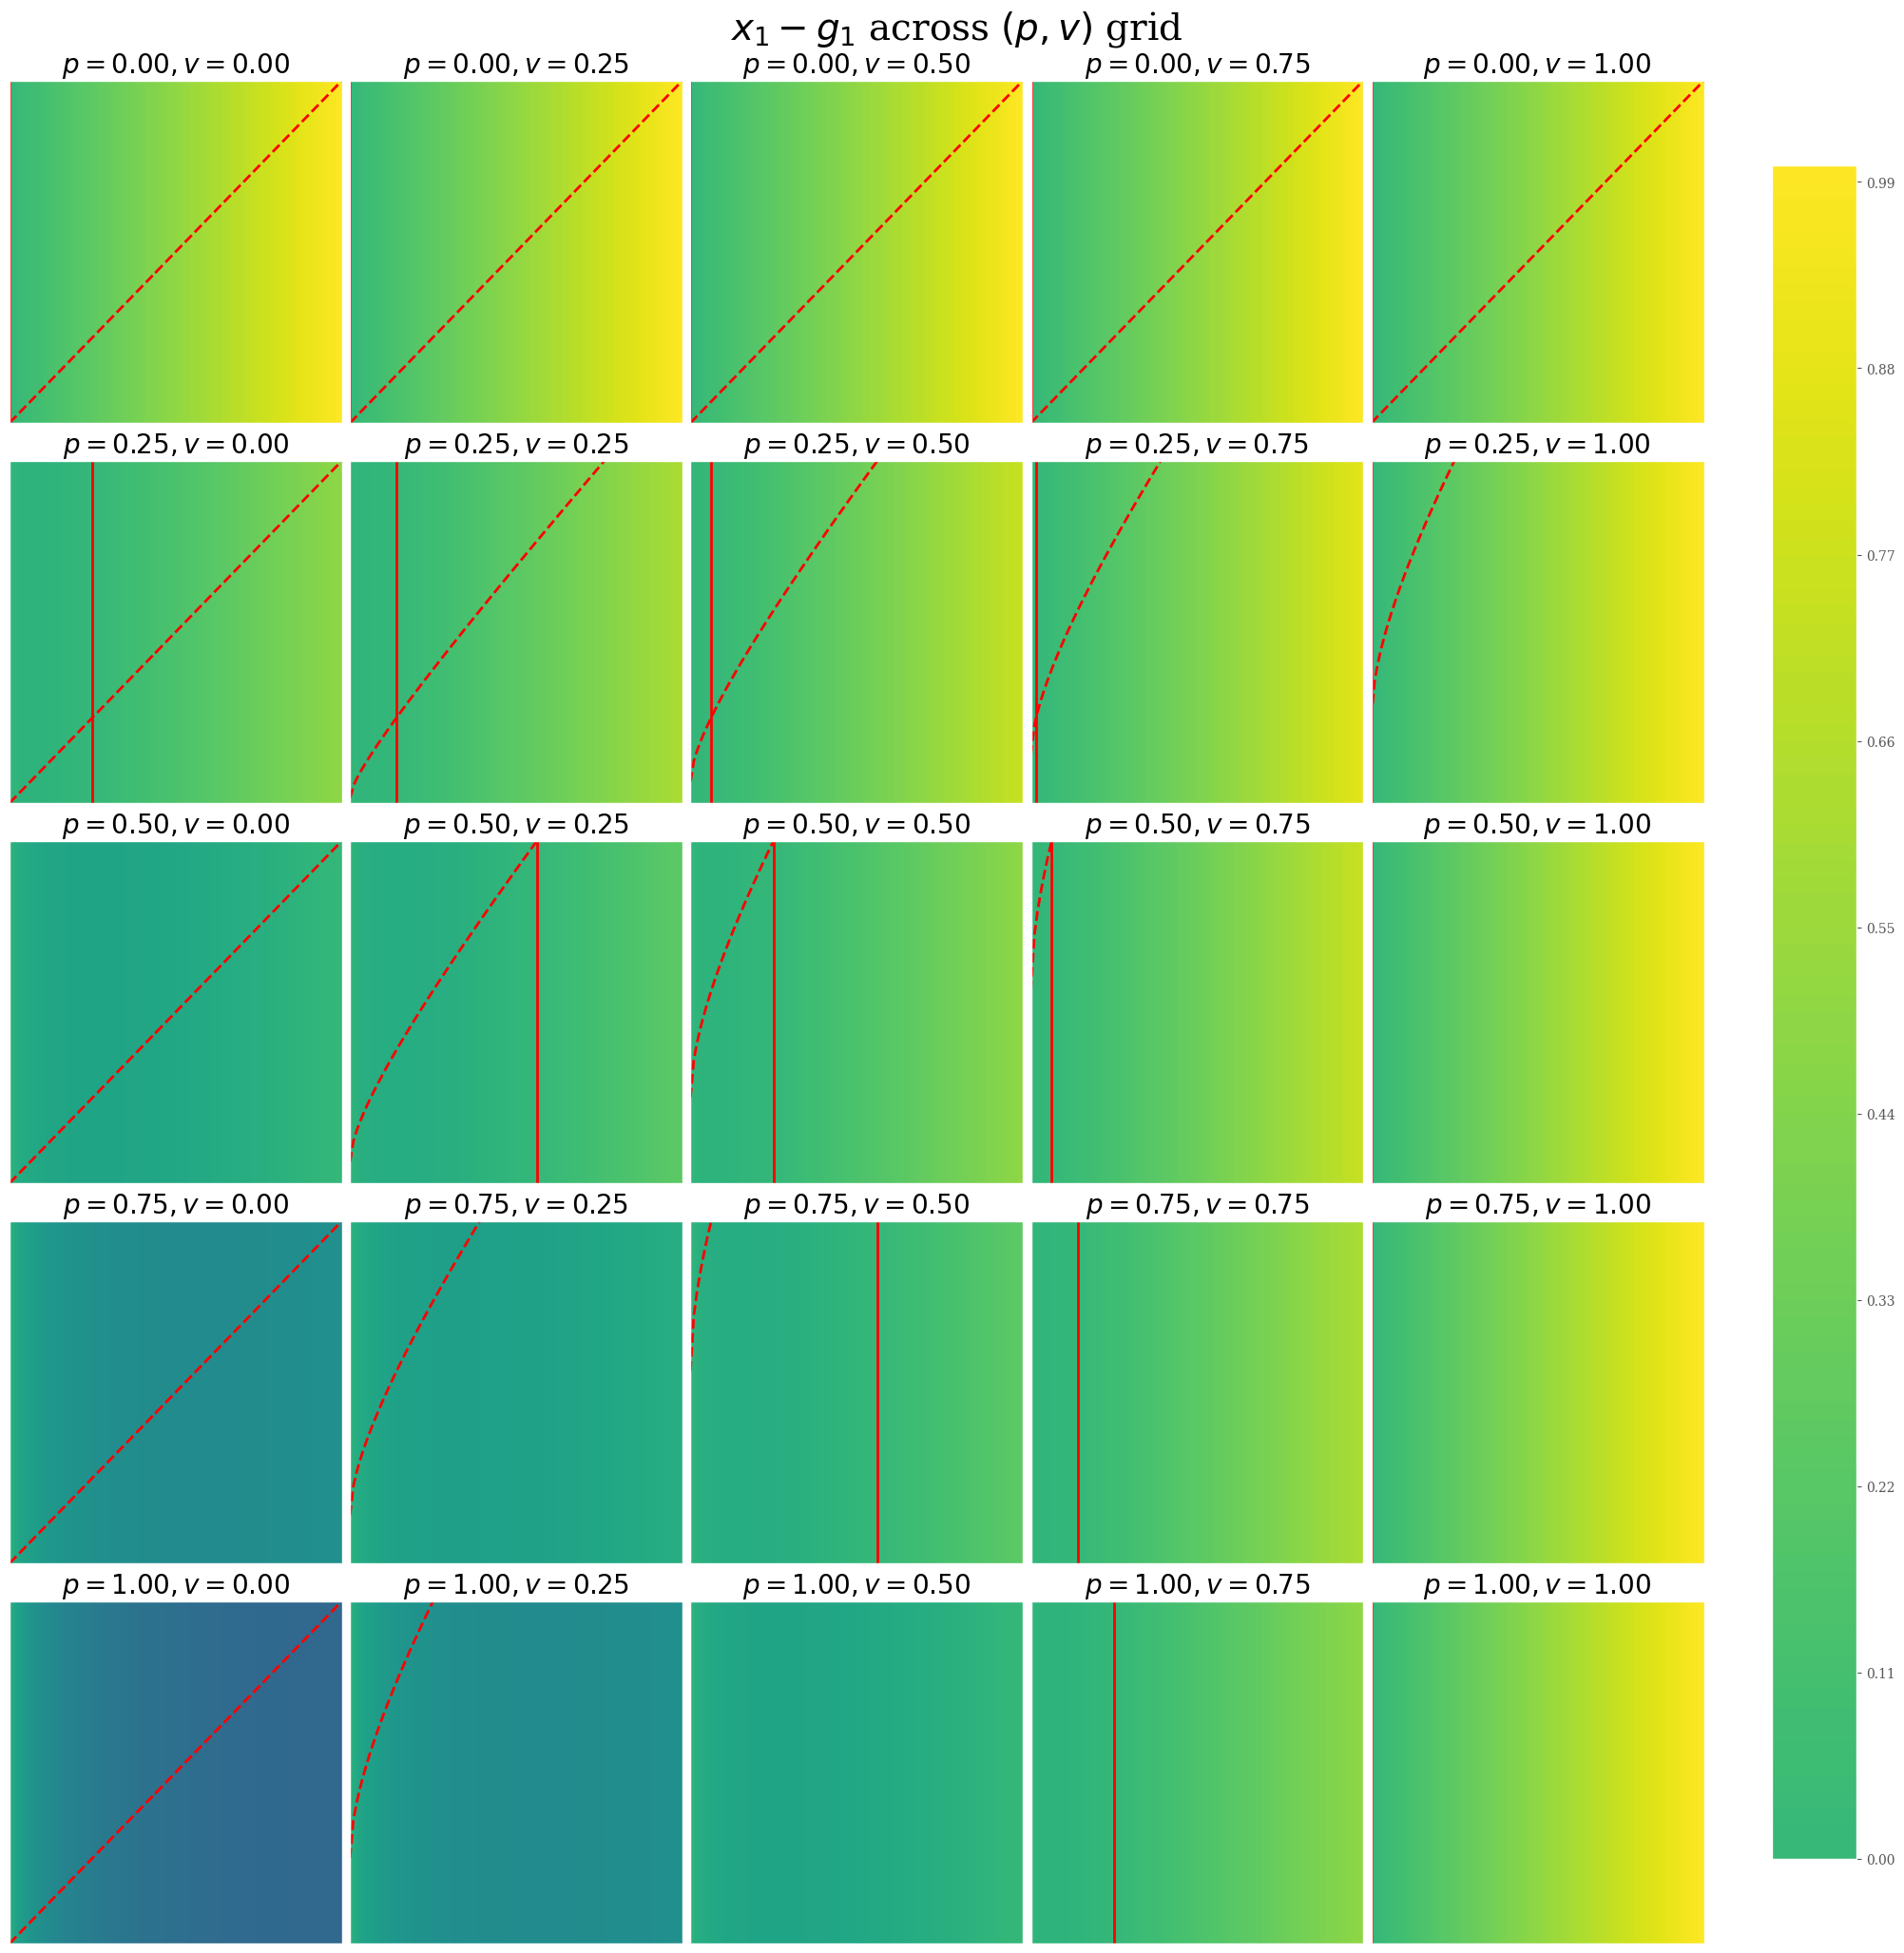

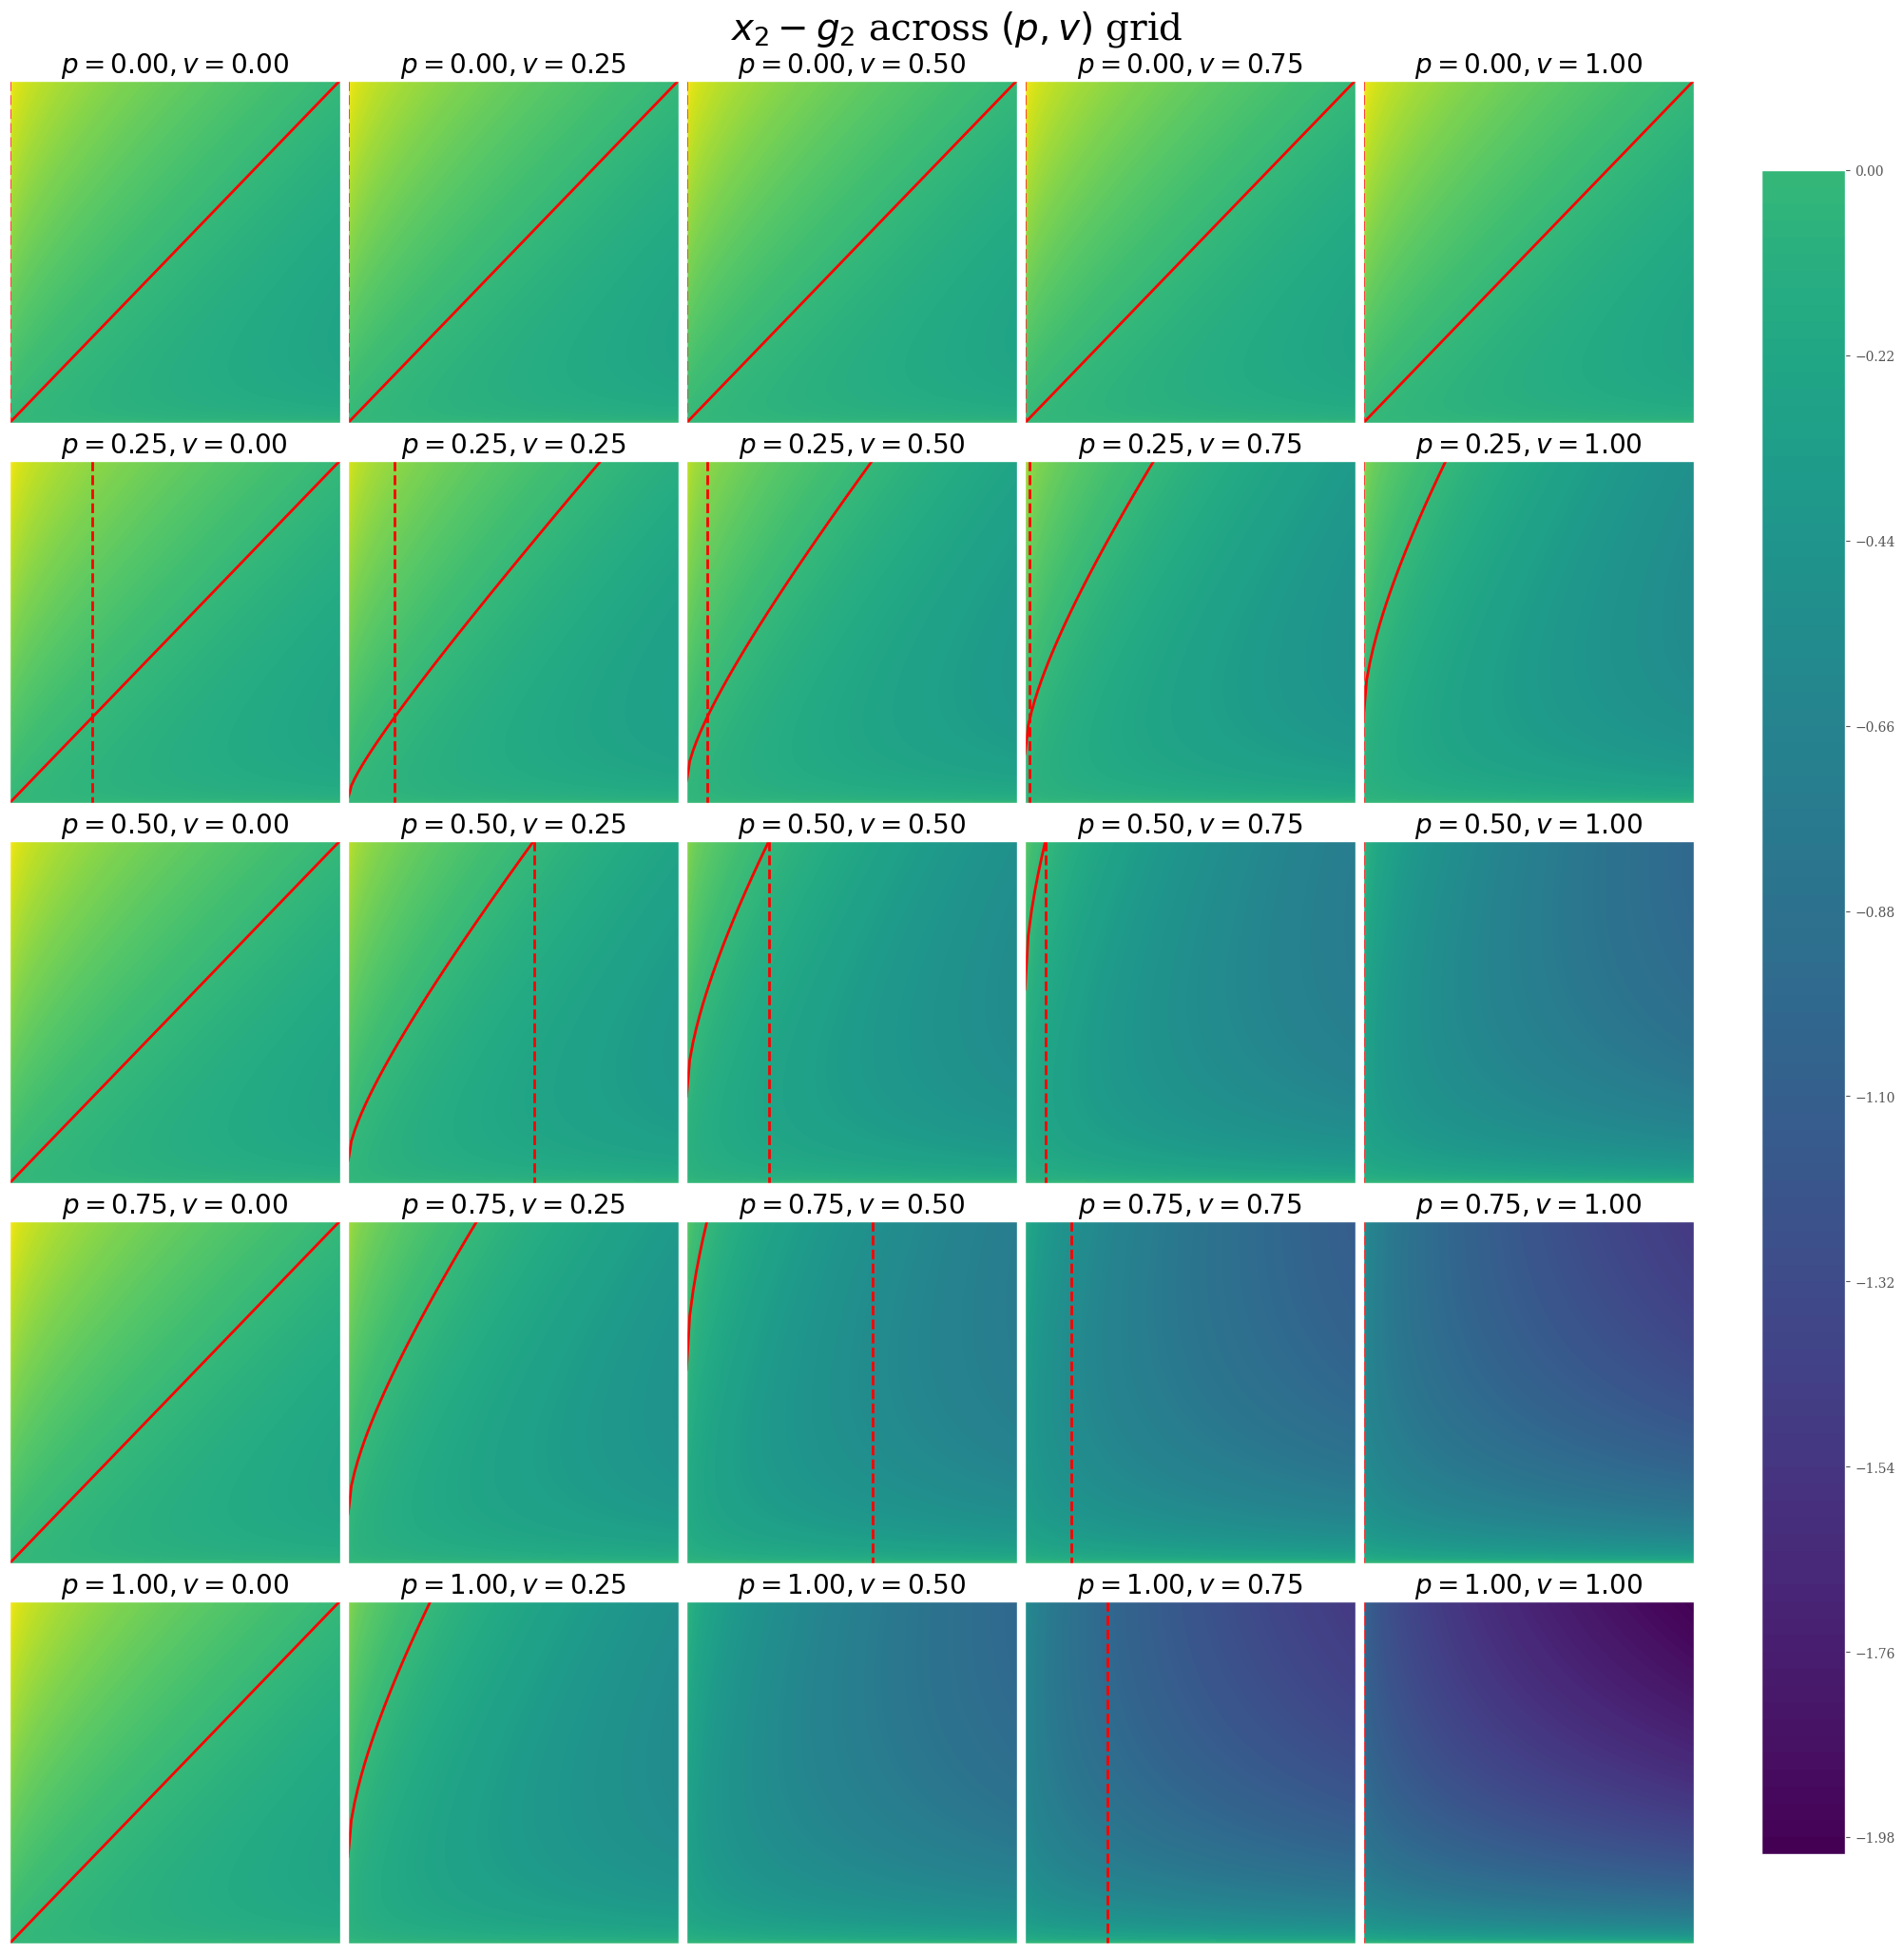

In [57]:
# Parameter grid
p_vals = np.linspace(0, 1, 5)
v_vals = np.linspace(0, 1, 5)

# Grid for evaluation
x1_lin = np.linspace(0, 1, 101)
x2_lin = np.linspace(0, 1, 101)
X1, X2 = np.meshgrid(x1_lin, x2_lin)

# --- Compute global vmin/vmax across all (p,v) combinations ---
all_vals = []
for p in p_vals:
    for v in v_vals:
        Z1 = g1(x=X1, y=X2, p=p, v=v)
        Z2 = g2(x=X1, y=X2, p=p, v=v)
        all_vals.append((X1 - Z1).min())
        all_vals.append((X1 - Z1).max())
        all_vals.append((X2 - Z2).min())
        all_vals.append((X2 - Z2).max())

vmin = min(all_vals)
vmax = max(all_vals)

# ---------------- FIGURE 1: x1 - g1 ----------------
fig1, axes1 = plt.subplots(len(p_vals), len(v_vals), figsize=(20, 20), constrained_layout=True)

for i, p in enumerate(p_vals):
    for j, v in enumerate(v_vals):
        ax = axes1[i, j]

        Z1 = g1(x=X1, y=X2, p=p, v=v)
        Z2 = g2(x=X1, y=X2, p=p, v=v)

        im1 = ax.contourf(X1, X2, X1 - Z1, levels=100, vmin=vmin, vmax=vmax)
        ax.contour(X1, X2, X1 - Z1, levels=[0], colors='red', linewidths=2)
        ax.contour(X1, X2, X2 - Z2, levels=[0], colors='red', linewidths=2, linestyles='--')

        ax.set_title(rf"$p={p:.2f}, v={v:.2f}$", fontsize=20)
        ax.set_xticks([]); ax.set_yticks([])

fig1.colorbar(im1, ax=axes1.ravel().tolist(), fraction=0.05, pad=0.04)
fig1.suptitle(r"$x_1 - g_1$ across $(p,v)$ grid", size=28, y=1.02)


# ---------------- FIGURE 2: x2 - g2 ----------------
fig2, axes2 = plt.subplots(len(p_vals), len(v_vals), figsize=(20, 20), constrained_layout=True)

for i, p in enumerate(p_vals):
    for j, v in enumerate(v_vals):
        ax = axes2[i, j]

        Z1 = g1(x=X1, y=X2, p=p, v=v)
        Z2 = g2(x=X1, y=X2, p=p, v=v)

        im2 = ax.contourf(X1, X2, X2 - Z2, levels=100, vmin=vmin, vmax=vmax)
        ax.contour(X1, X2, X2 - Z2, levels=[0], colors='red', linewidths=2)
        ax.contour(X1, X2, X1 - Z1, levels=[0], colors='red', linewidths=2, linestyles='--')

        ax.set_title(rf"$p={p:.2f}, v={v:.2f}$", fontsize=20)
        ax.set_xticks([]); ax.set_yticks([])

fig2.colorbar(im2, ax=axes2.ravel().tolist(), fraction=0.05, pad=0.04)
fig2.suptitle(r"$x_2 - g_2$ across $(p,v)$ grid", size=28, y=1.02)

plt.show()


## soft penalty
(idea but probably won't do this---depends on analysis)
$$
\dot x = F(x) + h(x)
$$
where $F$ is two tank system and $h$ is boundary penalty given by 
$$
h(x) = \begin{cases}
 0, & x < 1 - \epsilon\\
 - \texttt{Relu}(x), & \text{else}
\end{cases}
$$

Can replace $\texttt{Relu}$ with something else as well.

## Modified system with modified flow rate coefficients 

**System:**
$$
\begin{align}
\frac{d x_1}{dt} &= c_1^{\text{in}}(1-v)p - c_1^{\text{out}} \sqrt{x_1}\\
\frac{d x_2}{dt} &= c_2^{\text{in}} v p + c_1^{\text{out}} \sqrt{x_1} - c_2^{\text{out}} \sqrt{x_2}
\end{align}
$$

where

$$
\begin{split}
    c_1^{\text{in}} &\triangleq q_1(1-\sigma_\gamma(x_1-b_1) )\\
    c_2^{\text{in}} &\triangleq q_1 (1-\sigma_\gamma(x_2 - b_2))\\
    c_1^{\text{out}} &\triangleq q_2 (1-\sigma_\gamma(x_2 - b_2))\\
    c_2^{\text{out}} &\triangleq q_2
\end{split}
$$

Where $\sigma_\gamma(x)= \frac{1}{1+\exp{-\gamma x}}$ is the sigmoid function. $q_1$, $q_2$ are the flow rates coefficients in and out of both tanks, respectively, in an unconstrained system. $b_1$ and $b_2$ are the physical limits of the system, restricting the flow rate into each tank, respectively. 

Note that $x_2^{\text{out}}$ is constant since we assume the flow out of tank $2$ falls in an unconstrained reservoir.

In [33]:
gamma = 50
def sigmoid(x,gamma=gamma):
    return 1 / (1+np.exp(-gamma*x))

In [34]:
eps = 0.02
q1, q2 = c1, c2
b1 = 1-eps
b2 = 1-eps

In [35]:
def c1_in(x):
    return q1*(1-sigmoid(x-b1))

def c2_in(y):
    return q1*(1-sigmoid(y-b2))

def c1_out(y):
    return q2*(1-sigmoid(y-b2))

def c2_out(y):
    return q2

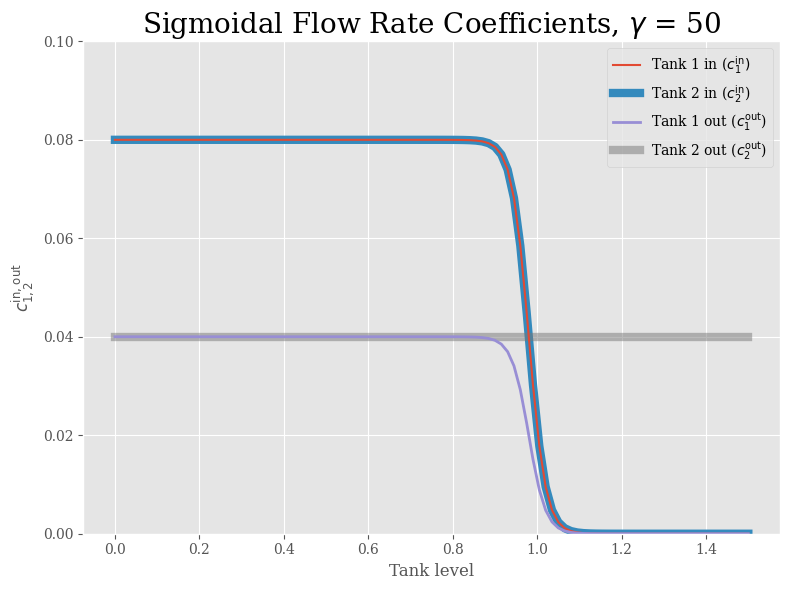

In [53]:
x_lin = np.linspace(0,1.5,101)

plt.figure(figsize=(8,6))
plt.title(rf"Sigmoidal Flow Rate Coefficients, $\gamma$ = {gamma}",size=20)
plt.plot(x_lin, c1_in(x_lin),zorder=2,label=r"Tank 1 in ($c_{1}^{\text{in}})$")
plt.plot(x_lin, c2_in(x_lin),lw=6,zorder=1, label=r"Tank 2 in ($c_{2}^{\text{in}}$)")
plt.plot(x_lin, c1_out(x_lin),label=r"Tank 1 out ($c_1^{\text{out}}$)",lw=2)
plt.plot(x_lin, [c2_out(xi) for xi in x_lin],label=r"Tank 2 out ($c_2^{\text{out}}$)",lw=6,zorder=1,alpha=0.5)
plt.xlabel(r"Tank level")
plt.ylabel(r"$c_{1,2}^{\text{in, out}}$")
plt.ylim(0,0.1)
plt.legend()
plt.tight_layout()
plt.show()

## Define two_tank_system

In [37]:
from scipy.integrate import solve_ivp

In [38]:
def two_tank_system(t,x,u):
    x1, x2 = x
    p, v = u
    dx1dt = c1_in(x1)*(1-v)*p-c1_out(x2)*np.sqrt(x1)
    dx2dt = c2_in(x2)*v*p +c1_out(x2)*np.sqrt(x1)-q2*np.sqrt(x2)
    return np.hstack([dx1dt,dx2dt])

In [39]:
t_max = 300
x0 = [0.5,0.5]
u = [1,0.2]

In [40]:

sol = solve_ivp(
    two_tank_system,
    t_span = [0,t_max],
    y0 = x0,
    t_eval= np.linspace(0,t_max, 1001),
    args =(u,)
)

In [41]:
t = sol.t
X = sol.y
X.min(), X.max()

(0.5, 0.9866730855385965)

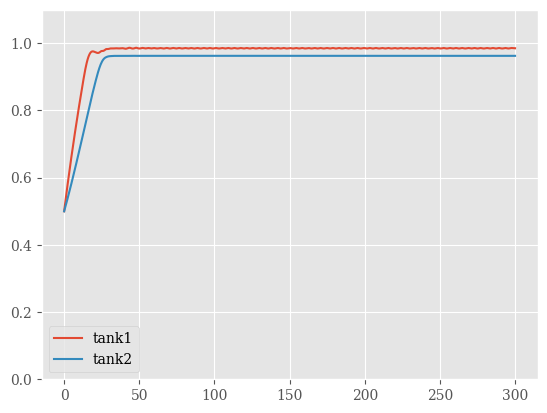

In [42]:
plt.plot(t, X[0,:],label='tank1')
plt.plot(t, X[1,:],label='tank2')
plt.ylim(0,1.1)
plt.legend()
plt.show()

## Big grid experiment

In [369]:
p_vals = np.linspace(0,1,101)
v_vals = np.linspace(0,1,101)

x0 = [0.5,0.5]

X1s = np.zeros((len(p_vals),len(v_vals)))
X2s = np.zeros((len(p_vals),len(v_vals)))

for i, pi in enumerate(tqdm(p_vals)):
    for j, vi in enumerate(tqdm(v_vals,leave=False)):
        t_max = 300
        x0 = [0.5,0.5]
        u = np.array([pi,vi])
        sol = solve_ivp(
            two_tank_system,
            t_span = [0,t_max],
            y0 = np.array(x0),
            t_eval= np.linspace(0,t_max, 501),
            args =(u,)
        )
        x1, x2 = sol.y[:,-1]
        X1s[i,j] = x1
        X2s[i,j] = x2

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

/var/folders/9x/8bf0hckd1b122g3zlj_z9c1w0000gp/T/ipykernel_82853/1265693017.py:4: RuntimeWarning: invalid value encountered in sqrt
  dx1dt = c1_in(x1)*(1-v)*p-c1_out(x2)*np.sqrt(x1)
/var/folders/9x/8bf0hckd1b122g3zlj_z9c1w0000gp/T/ipykernel_82853/1265693017.py:5: RuntimeWarning: invalid value encountered in sqrt
  dx2dt = c2_in(x2)*v*p +c1_out(x2)*np.sqrt(x1)-q2*np.sqrt(x2)


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

/var/folders/9x/8bf0hckd1b122g3zlj_z9c1w0000gp/T/ipykernel_82853/828621276.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1+np.exp(-gamma*x))


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

In [370]:
X1s.max(), X1s.min(), X2s.max(), X2s.min()

(0.9855974425656145,
 9.876009698543361e-09,
 0.9888817008593507,
 0.0003983704281731535)

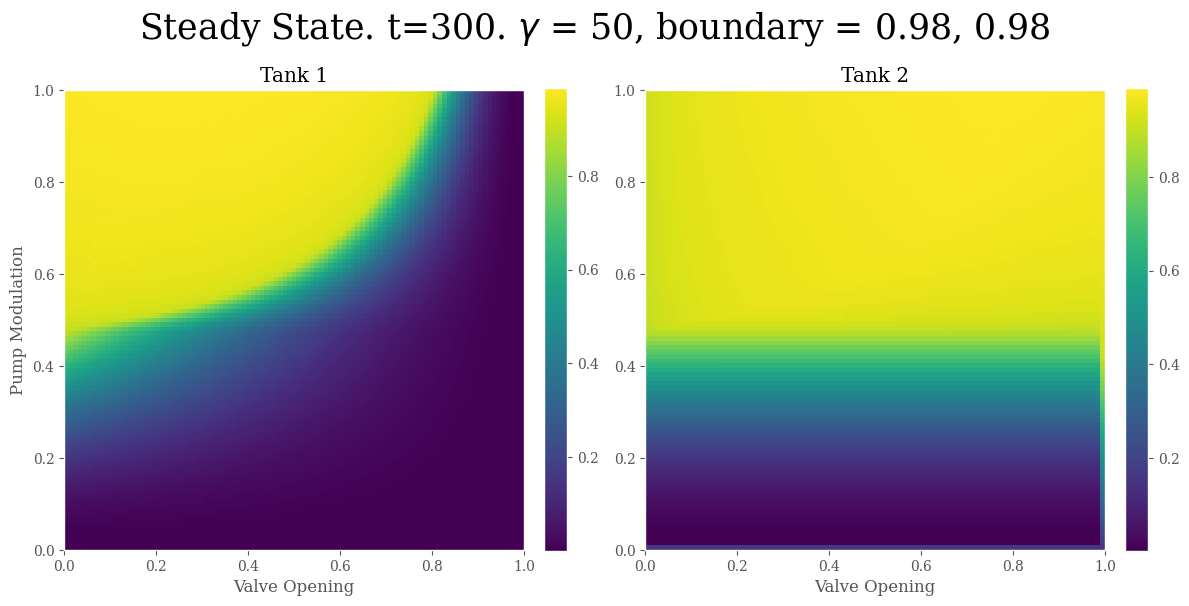

In [371]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
im1 = ax1.imshow(X1s,extent=[v_vals[0],v_vals[-1],p_vals[0],p_vals[-1]],origin='lower')
cbar1 = fig.colorbar(im1,ax=ax1,fraction=0.046,pad=0.04)
ax1.set_ylabel("Pump Modulation")
ax1.set_xlabel("Valve Opening")
ax1.set_title("Tank 1")
ax1.grid(False)

im2 = ax2.imshow(X2s,extent=[v_vals[0],v_vals[-1],p_vals[0],p_vals[-1]],origin='lower')
cbar2 = fig.colorbar(im2,ax=ax2,fraction=0.046,pad=0.04)
ax2.set_xlabel("Valve Opening")
ax2.set_title("Tank 2")
ax2.grid(False)

plt.suptitle(rf"Steady State. t={t_max}. $\gamma$ = {gamma}, boundary = {b1}, {b2}",size=25)
plt.tight_layout()

## Analytical Steady States away from boundaries

In [63]:
def g1(x,y,p,v,c1=q1,c2=q2):
    return (1-v)*p*c1/c2*np.sqrt(x)

def g2(x,y,p,v,c1=q1,c2=q2):
    return x+v*p*c1/c2*(np.sqrt(x)+np.sqrt(y))

# def g2(x,y,p,v,c1=q1,c2=q2):
#     return np.sqrt(y)*(np.sqrt(x)+c1/c2*v*p)

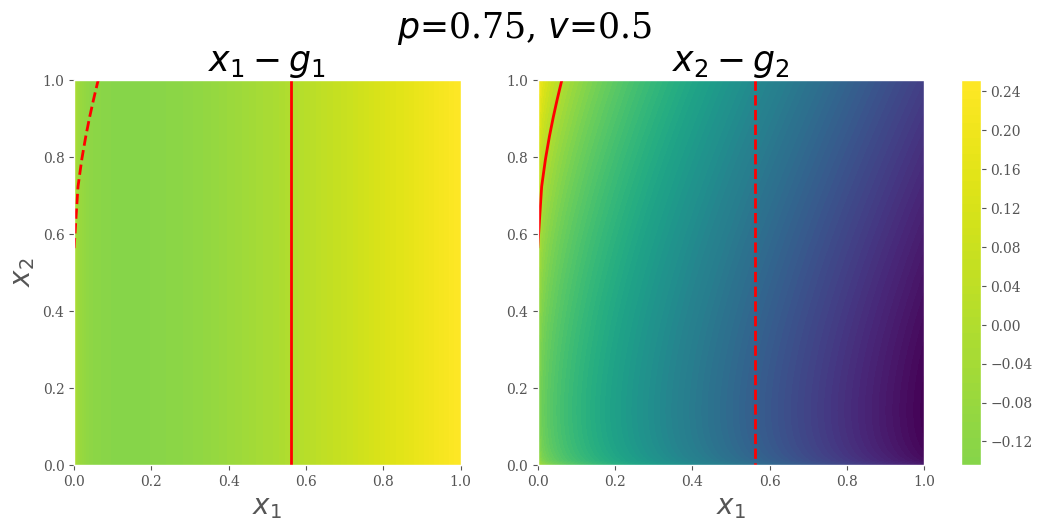

In [64]:
p = 0.75
v = 0.5

x1_lin = np.linspace(0,1,101)
x2_lin = np.linspace(0,1,101)

X1, X2 = np.meshgrid(x1_lin,x2_lin)

Z1 = g1(x=X1,y=X2,p=p,v=v)
Z2 = g2(x=X1,y=X2,p=p,v=v)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))


vmin = min((X1 - Z1).min(), (X2 - Z2).min())
vmax = max((X1 - Z1).max(), (X2 - Z2).max())
# vmin=None
# vmax=None

im1 = ax1.contourf(X1, X2, X1 - Z1, levels=100, vmin=vmin, vmax=vmax)
im2 = ax2.contourf(X1, X2, X2 - Z2, levels=100, vmin=vmin, vmax=vmax)

ax1.contour(X1, X2, X1 - Z1, levels=[0], colors='red', linewidths=2)
ax2.contour(X1, X2, X2 - Z2, levels=[0], colors='red', linewidths=2)

ax2.contour(X1, X2, X1 - Z1, levels=[0], colors='red', linewidths=2,linestyles='--')
ax1.contour(X1, X2, X2 - Z2, levels=[0], colors='red', linewidths=2,linestyles='--')

cbar = fig.colorbar(im1, ax=[ax1, ax2], fraction=0.046, pad=0.04)

ax1.set_ylabel(r"$x_2$", size=20)
ax1.set_xlabel(r"$x_1$", size=20)
ax1.set_title(r"$x_1 - g_1$", size=25)

ax2.set_xlabel(r"$x_1$", size=20)
ax2.set_title(r"$x_2 - g_2$", size=25)

# plt.tight_layout()
plt.suptitle(rf"$p$={p}, $v$={v}",size=25,y=1.02)
plt.show()


In [65]:
def two_tank_system(t,x,u):
    x1, x2 = x
    p, v = u
    x1= np.maximum(x1,0)
    x2 = np.maximum(x2,0)
    dx1dt = c1_in(x1)*(1-v)*p-c1_out(x2)*np.sqrt(x1)
    dx2dt = c2_in(x2)*v*p +c1_out(x2)*np.sqrt(x1)-q2*np.sqrt(x2)
    return np.hstack([dx1dt,dx2dt])

In [66]:
q2, q1

(0.04, 0.08)

In [67]:
# True steady state
p_vals = np.linspace(0, 1, 11)
v_vals = np.linspace(0, 1, 11)

x0 = [0.5,0.5]

X1steady = np.zeros((len(p_vals),len(v_vals)))
X2steady = np.zeros((len(p_vals),len(v_vals)))

for i, pi in enumerate(tqdm(p_vals)):
    for j, vi in enumerate(tqdm(v_vals,leave=False)):
        t_max = 300
        x0 = [0.5,0.5]
        u = np.array([pi,vi])
        sol = solve_ivp(
            two_tank_system,
            t_span = [0,t_max],
            y0 = np.array(x0),
            t_eval= np.linspace(0,t_max, 501),
            args =(u,)
        )
        x1, x2 = sol.y[:,-1]
        X1steady[i,j] = x1
        X2steady[i,j] = x2

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

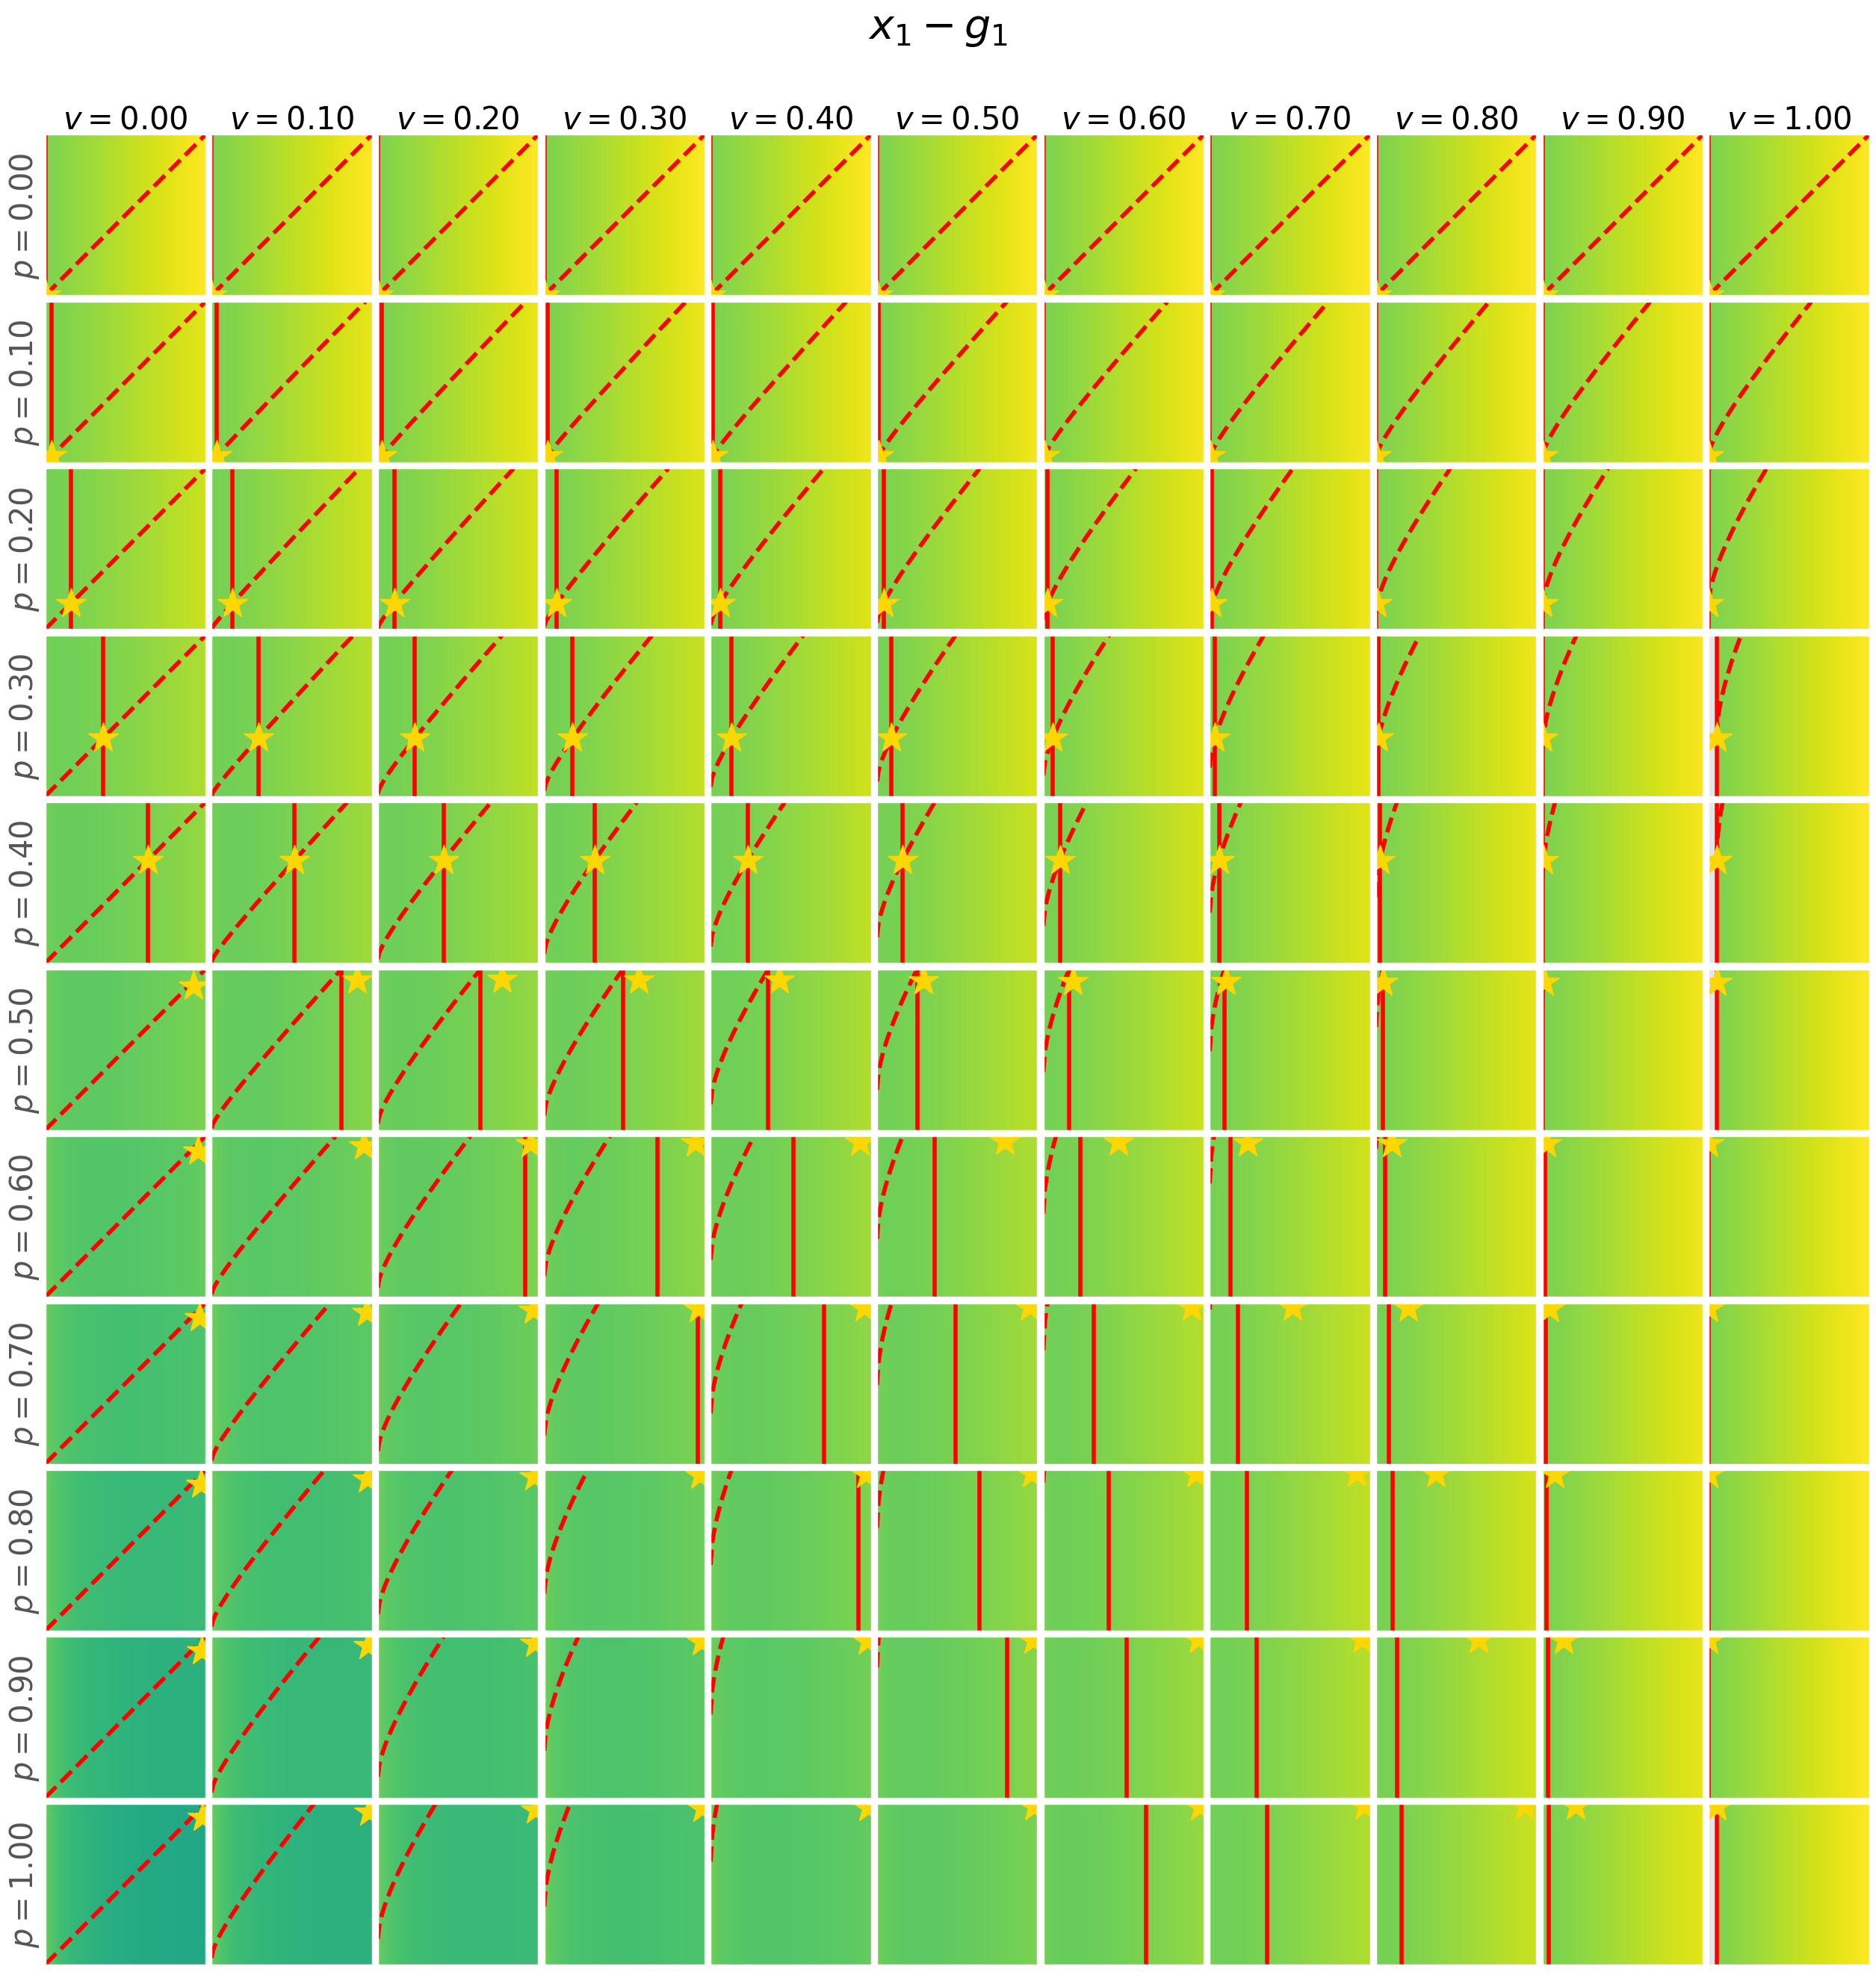

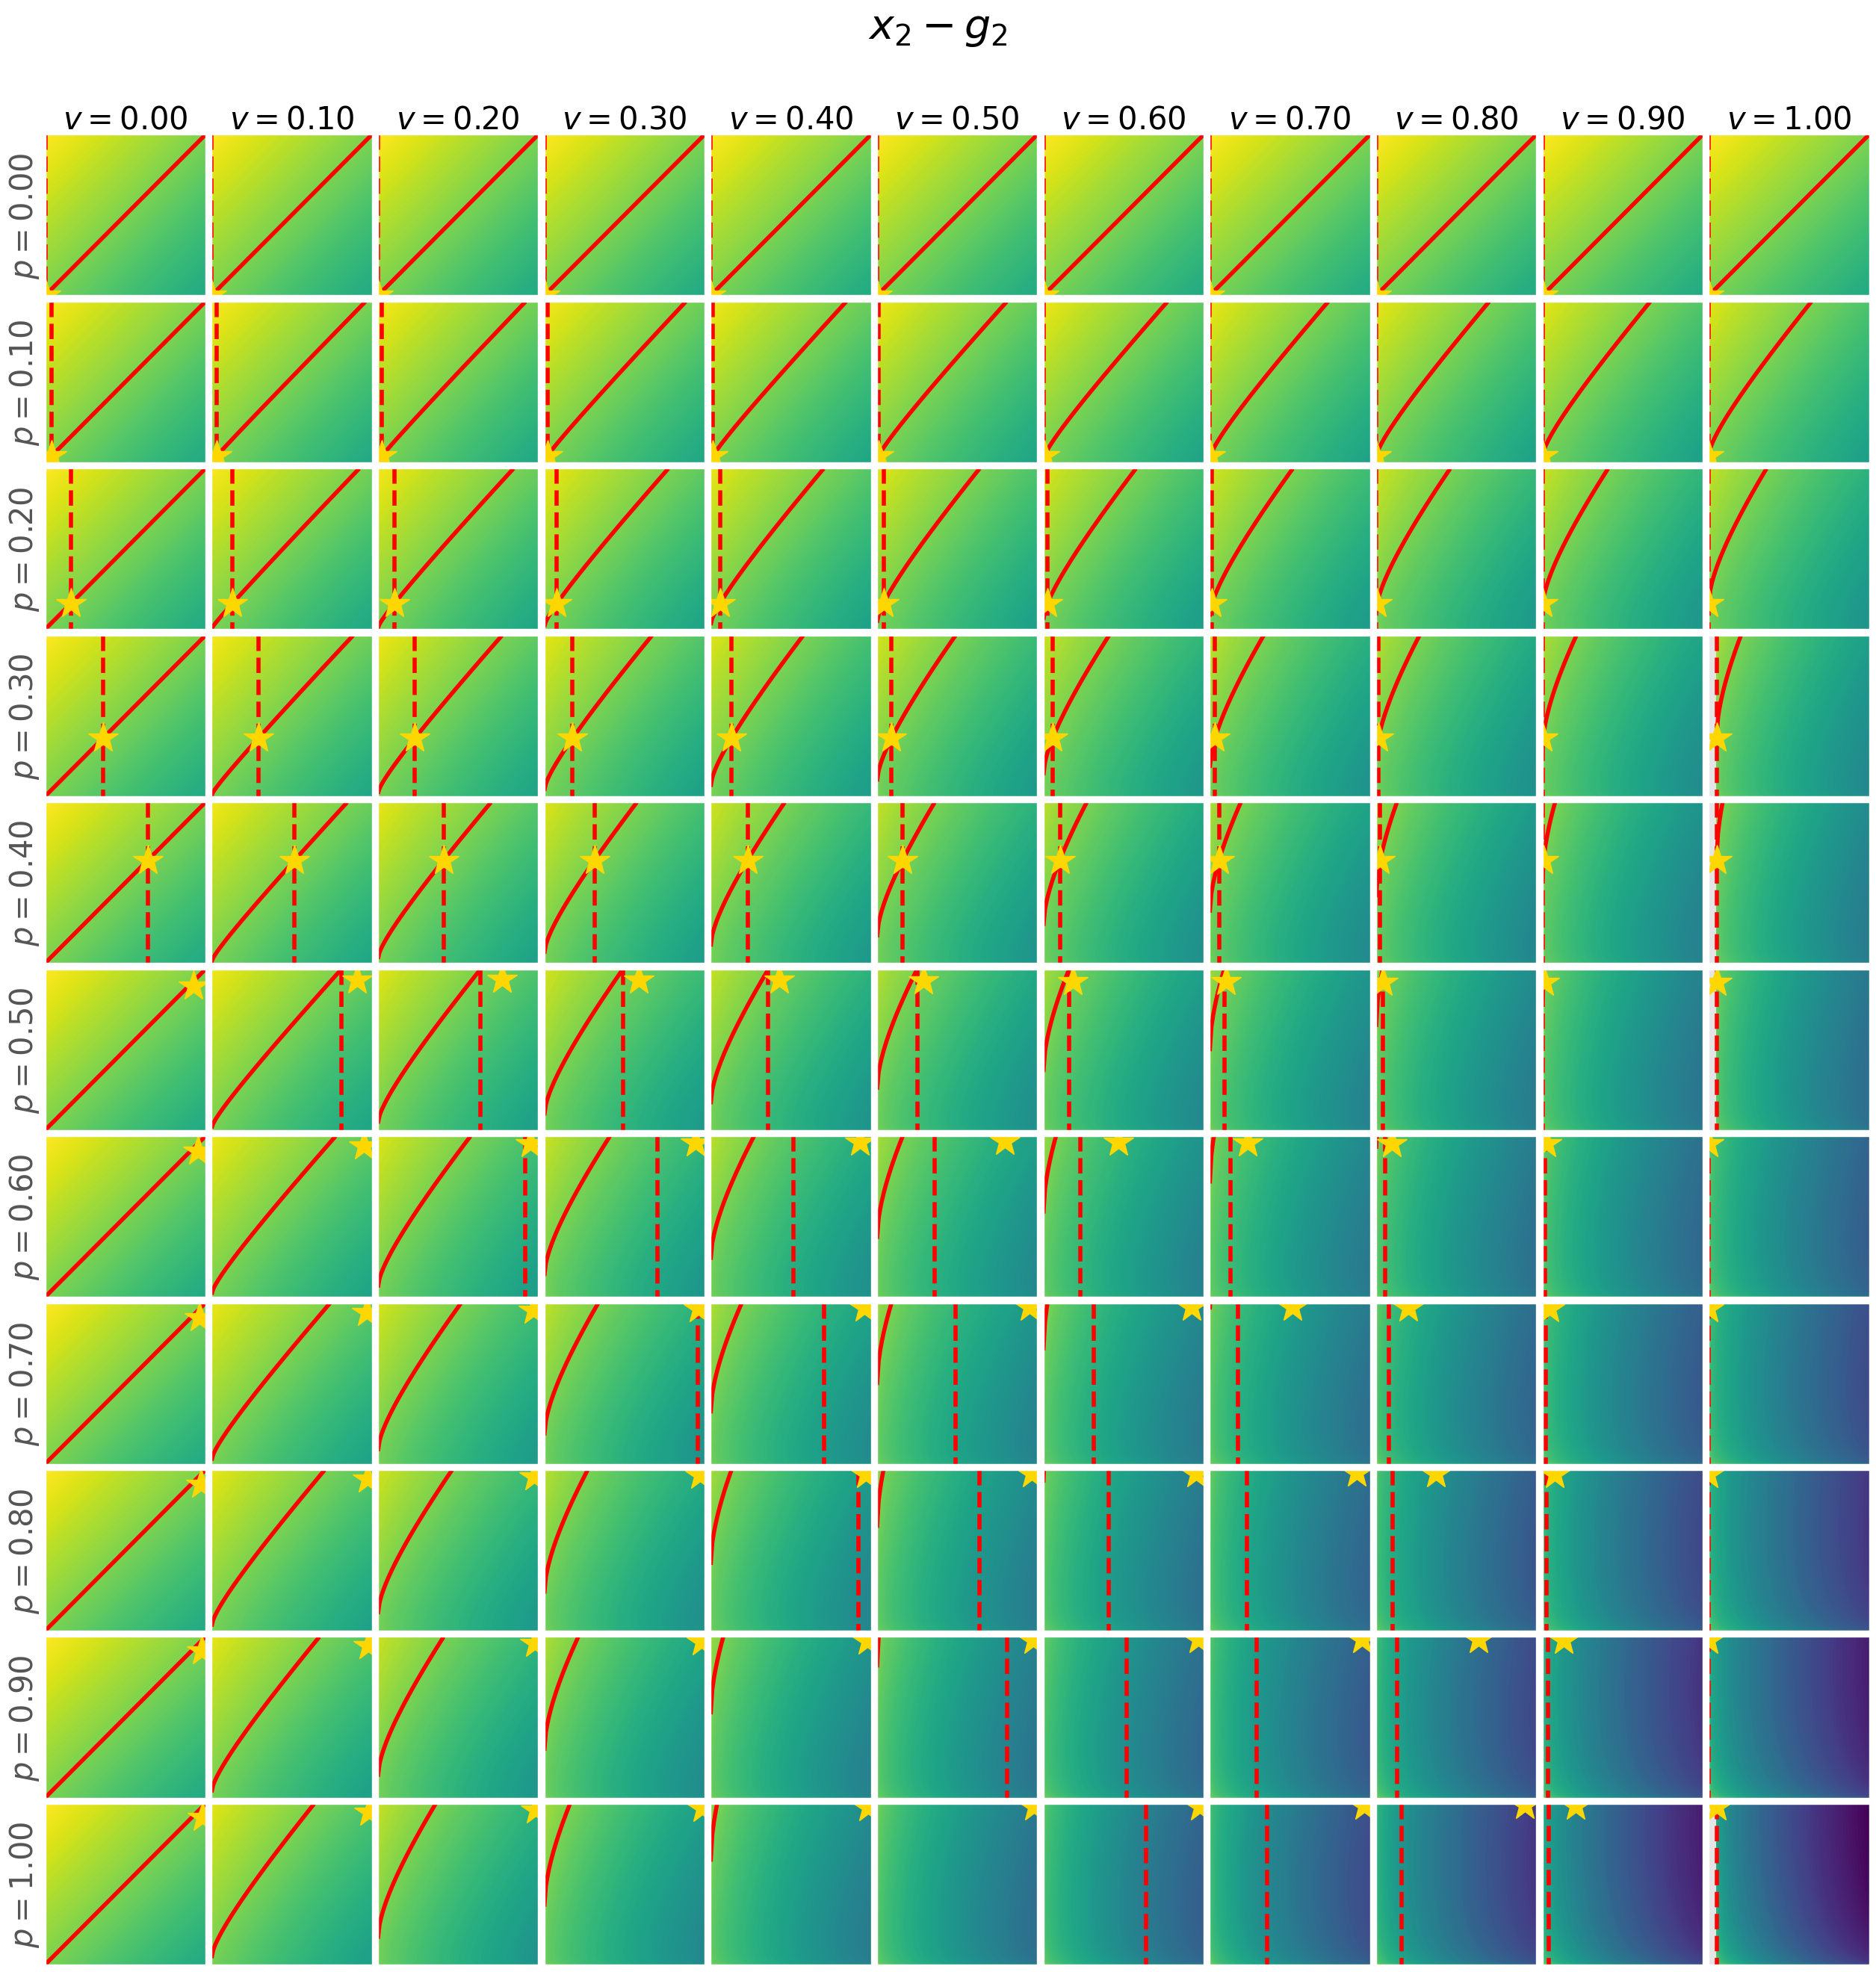

In [68]:
# Parameter grid
p_vals = np.linspace(0, 1, 11)
v_vals = np.linspace(0, 1, 11)

# Grid for evaluation
x1_lin = np.linspace(0, 1, 101)
x2_lin = np.linspace(0, 1, 101)
X1, X2 = np.meshgrid(x1_lin, x2_lin)

lw = 4

# --- Compute global vmin/vmax across all (p,v) combinations ---
all_vals = []
for p in tqdm(p_vals):
    for v in v_vals:
        Z1 = g1(x=X1, y=X2, p=p, v=v)
        Z2 = g2(x=X1, y=X2, p=p, v=v)
        all_vals.append((X1 - Z1).min())
        all_vals.append((X1 - Z1).max())
        all_vals.append((X2 - Z2).min())
        all_vals.append((X2 - Z2).max())

vmin = min(all_vals)
vmax = max(all_vals)

# ---------------- FIGURE 1: x1 - g1 ----------------
fig1, axes1 = plt.subplots(len(p_vals), len(v_vals), figsize=(25, 25), constrained_layout=True)

for i, p in enumerate(p_vals):
    for j, v in enumerate(v_vals):
        ax = axes1[i, j]

        Z1 = g1(x=X1, y=X2, p=p, v=v)
        Z2 = g2(x=X1, y=X2, p=p, v=v)

        im1 = ax.contourf(X1, X2, X1 - Z1, levels=100, vmin=vmin, vmax=vmax)
        ax.contour(X1, X2, X1 - Z1, levels=[0], colors='red', linewidths=lw)
        ax.contour(X1, X2, X2 - Z2, levels=[0], colors='red', linewidths=lw, linestyles='--')
        x_star, y_star = X1steady[i,j], X2steady[i,j]
        ax.plot(x_star, y_star, marker='*', color='gold', markersize=30)
        if i == 0:  
            ax.set_title(rf"$v={v:.2f}$", fontsize=30)
        if j==0:
            ax.set_ylabel(rf"$p={p:.2f}$",fontsize=30,fontweight='bold')
        ax.set_xticks([]); ax.set_yticks([])

# fig1.colorbar(im1, ax=axes1.ravel().tolist(), fraction=0.05, pad=0.04)
fig1.suptitle(r"$x_1 - g_1$", size=40, y=1.05)


# ---------------- FIGURE 2: x2 - g2 ----------------
fig2, axes2 = plt.subplots(len(p_vals), len(v_vals), figsize=(25, 25), constrained_layout=True)

for i, p in enumerate(p_vals):
    for j, v in enumerate(v_vals):
        ax = axes2[i, j]

        Z1 = g1(x=X1, y=X2, p=p, v=v)
        Z2 = g2(x=X1, y=X2, p=p, v=v)

        im2 = ax.contourf(X1, X2, X2 - Z2, levels=100, vmin=vmin, vmax=vmax)
        ax.contour(X1, X2, X2 - Z2, levels=[0], colors='red', linewidths=lw)
        ax.contour(X1, X2, X1 - Z1, levels=[0], colors='red', linewidths=lw, linestyles='--')
        x_star, y_star = X1steady[i,j], X2steady[i,j]
        ax.plot(x_star, y_star, marker='*', color='gold', markersize=30)
        if i == 0:  
            ax.set_title(rf"$v={v:.2f}$", fontsize=30)
        if j==0:
            ax.set_ylabel(rf"$p={p:.2f}$",fontsize=30,fontweight='bold')
        ax.set_xticks([]); ax.set_yticks([])

# fig2.colorbar(im2, ax=axes2.ravel().tolist(), fraction=0.05, pad=0.04)
fig2.suptitle(r"$x_2 - g_2$", size=40, y=1.05)

plt.show()
